The goal of this notebook is to remove multicollinearity in our dataset programmatically. We want to take in a dataset, identify pairs of highly correlated predictor (independent) variables (corr. above .7), and remove the predictor variable with the higher variance within the pair.

## 1. Importing Data, Subsetting and Removing IDs

In [157]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [158]:
gdrive_url = 'https://drive.google.com/file/d/1U2UaHWRSkUXfJBn4kBHPYttd3dvw_CZF/view?usp=drive_link'

file_id = '1U2UaHWRSkUXfJBn4kBHPYttd3dvw_CZF'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url, encoding='utf-8')
df.head()

,game_id,season,team_id,team_name,tri_code,team_slug,minutes,field_goals_made,field_goals_attempted,field_goals_percentage,...,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,is_home_team,won_game,is_playoff_game,is_regular_game
0,40400407,2004-05,1610612759,Spurs,SAS,spurs,240:00,29.0,68.0,0.426,...,0.0,0.426,0.0,0.0,0.0,74.0,1,1,1,0
1,40400406,2004-05,1610612759,Spurs,SAS,spurs,240:00,31.0,75.0,0.413,...,0.0,0.413,0.0,0.0,0.0,95.0,1,0,1,0
2,40400405,2004-05,1610612765,Pistons,DET,pistons,265:00,37.0,84.0,0.440,...,0.0,0.440,0.0,0.0,0.0,96.0,1,0,1,0
3,40400404,2004-05,1610612765,Pistons,DET,pistons,240:00,41.0,90.0,0.456,...,0.0,0.456,0.0,0.0,0.0,71.0,1,1,1,0
4,40400403,2004-05,1610612765,Pistons,DET,pistons,240:00,40.0,85.0,0.471,...,0.0,0.471,0.0,0.0,0.0,79.0,1,1,1,0


Now we will filter for game data after 2014 (this is to reduce missing data errors that exist before 2014)

In [159]:
print(f'Dropping Seasons:\n  Seasons before Dropping: {df.season.unique()}') 
df = df[df['season'].str[:4].astype(int) > 2013] # Remove old seasons (this was causing issues)
print(f'  The seasons are now: {df.season.unique()}\n') 

Dropping Seasons:
  Seasons before Dropping: ['2004-05' '2005-06' '2006-07' '2007-08' '2008-09' '2009-10' '2010-11'
 '2011-12' '2012-13' '2013-14' '2014-15' '2015-16' '2016-17' '2017-18'
 '2018-19' '2019-20' '2020-21' '2021-22' '2022-23' '2023-24']
  The seasons are now: ['2014-15' '2015-16' '2016-17' '2017-18' '2018-19' '2019-20' '2020-21'
 '2021-22' '2022-23' '2023-24']



Then, filter the dataset for only numeric data (we want to remove unnecessary categorical data that should not be turned into dummy variables)

In [160]:
df_numeric = df.select_dtypes('number') # Filter for only numbers

to_drop = ['game_id','team_id', 'is_home_team'] # Drop IDs
df_dropped_ids = df_numeric.drop(to_drop, axis=1)

df_dropped_ids.head()

,field_goals_made,field_goals_attempted,field_goals_percentage,three_pointers_made,three_pointers_attempted,three_pointers_percentage,free_throws_made,free_throws_attempted,free_throws_percentage,rebounds_offensive,...,uncontested_field_goals_attempted,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,won_game,is_playoff_game,is_regular_game
13932,32.0,82.0,0.390,6.0,26.0,0.231,27.0,39.0,0.692,16.0,...,38.0,0.316,0.390,17.0,28.0,0.607,105.0,0,1,0
13933,36.0,75.0,0.480,12.0,26.0,0.462,20.0,34.0,0.588,11.0,...,42.0,0.548,0.480,11.0,22.0,0.500,91.0,1,1,0
13934,29.0,88.0,0.330,4.0,27.0,0.148,20.0,28.0,0.714,16.0,...,42.0,0.238,0.330,9.0,14.0,0.643,103.0,0,1,0
13935,35.0,76.0,0.461,9.0,21.0,0.429,17.0,24.0,0.708,6.0,...,30.0,0.467,0.461,12.0,24.0,0.500,91.0,1,1,0
13936,33.0,83.0,0.398,8.0,35.0,0.229,19.0,25.0,0.760,10.0,...,47.0,0.404,0.398,7.0,19.0,0.368,95.0,0,1,0


In [161]:
df_dropped_ids.dropna()

,field_goals_made,field_goals_attempted,field_goals_percentage,three_pointers_made,three_pointers_attempted,three_pointers_percentage,free_throws_made,free_throws_attempted,free_throws_percentage,rebounds_offensive,...,uncontested_field_goals_attempted,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,won_game,is_playoff_game,is_regular_game
13932,32.0,82.0,0.390,6.0,26.0,0.231,27.0,39.0,0.692,16.0,...,38.0,0.316,0.390,17.0,28.0,0.607,105.0,0,1,0
13933,36.0,75.0,0.480,12.0,26.0,0.462,20.0,34.0,0.588,11.0,...,42.0,0.548,0.480,11.0,22.0,0.500,91.0,1,1,0
13934,29.0,88.0,0.330,4.0,27.0,0.148,20.0,28.0,0.714,16.0,...,42.0,0.238,0.330,9.0,14.0,0.643,103.0,0,1,0
13935,35.0,76.0,0.461,9.0,21.0,0.429,17.0,24.0,0.708,6.0,...,30.0,0.467,0.461,12.0,24.0,0.500,91.0,1,1,0
13936,33.0,83.0,0.398,8.0,35.0,0.229,19.0,25.0,0.760,10.0,...,47.0,0.404,0.398,7.0,19.0,0.368,95.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55309,45.0,112.0,0.402,13.0,53.0,0.245,19.0,24.0,0.792,16.0,...,0.0,0.000,0.402,0.0,0.0,0.000,127.0,0,0,0
55310,42.0,95.0,0.442,14.0,37.0,0.378,32.0,38.0,0.842,11.0,...,0.0,0.000,0.442,0.0,0.0,0.000,126.0,1,0,0
55311,39.0,90.0,0.433,14.0,31.0,0.452,12.0,16.0,0.750,13.0,...,0.0,0.000,0.433,0.0,0.0,0.000,96.0,1,0,0
55312,34.0,85.0,0.400,12.0,32.0,0.375,9.0,17.0,0.529,9.0,...,0.0,0.000,0.410,0.0,0.0,0.000,103.0,0,0,0


We can confirm that each process above ran correctly with the following code.

We should see a minimum season of 2014-15 in the original dataframe, a dataset of only float64 and int64 types in `df_dropped_ids`, and no ID variables in `df_dropped_ids`.

In [162]:
print(f'Oldest Season in the Dataset: {df.season.min()}') # Check if seasons are correct
print(f'The dataset is made up of the types: {set(df_dropped_ids.dtypes)}') # Check if types are correct
id_cols = [col for col in df_dropped_ids.columns if 'id' in col]
print(f'The following ID columns still exist in the dataset (if [], removal succeeded): {id_cols}') # Check if ID cols exist

Oldest Season in the Dataset: 2014-15
The dataset is made up of the types: {dtype('int64'), dtype('float64')}
The following ID columns still exist in the dataset (if [], removal succeeded): []


Now that we have a cleaned dataset, we can begin to clean the Multicollinear Elements. Let's separate the predictor (independent) and response (dependent) variables and then take care of the highly correlated predictors.

In [163]:
y = df_dropped_ids['points']
X = df_dropped_ids.drop(columns=['points'], axis=1)

In [164]:
y

13932     97.0
13933    104.0
13934     82.0
13935     96.0
13936     93.0
         ...  
55309    122.0
55310    130.0
55311    104.0
55312     89.0
55313     99.0
Name: points, Length: 27450, dtype: float64

In [165]:
X.head(10)

,field_goals_made,field_goals_attempted,field_goals_percentage,three_pointers_made,three_pointers_attempted,three_pointers_percentage,free_throws_made,free_throws_attempted,free_throws_percentage,rebounds_offensive,...,uncontested_field_goals_attempted,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,won_game,is_playoff_game,is_regular_game
13932,32.0,82.0,0.390,6.0,26.0,0.231,27.0,39.0,0.692,16.0,...,38.0,0.316,0.390,17.0,28.0,0.607,105.0,0,1,0
13933,36.0,75.0,0.480,12.0,26.0,0.462,20.0,34.0,0.588,11.0,...,42.0,0.548,0.480,11.0,22.0,0.500,91.0,1,1,0
13934,29.0,88.0,0.330,4.0,27.0,0.148,20.0,28.0,0.714,16.0,...,42.0,0.238,0.330,9.0,14.0,0.643,103.0,0,1,0
13935,35.0,76.0,0.461,9.0,21.0,0.429,17.0,24.0,0.708,6.0,...,30.0,0.467,0.461,12.0,24.0,0.500,91.0,1,1,0
13936,33.0,83.0,0.398,8.0,35.0,0.229,19.0,25.0,0.760,10.0,...,47.0,0.404,0.398,7.0,19.0,0.368,95.0,0,1,0
13937,39.0,88.0,0.443,10.0,27.0,0.370,20.0,22.0,0.909,11.0,...,51.0,0.549,0.443,12.0,18.0,0.667,100.0,1,1,0
13938,37.0,91.0,0.407,9.0,29.0,0.310,21.0,31.0,0.677,19.0,...,57.0,0.421,0.407,17.0,28.0,0.607,90.0,1,1,0
13939,43.0,87.0,0.494,13.0,31.0,0.419,19.0,30.0,0.633,13.0,...,46.0,0.500,0.494,21.0,28.0,0.750,88.0,1,1,0
13940,43.0,76.0,0.566,17.0,32.0,0.531,25.0,43.0,0.581,4.0,...,38.0,0.579,0.566,16.0,24.0,0.667,115.0,1,1,0
13941,40.0,97.0,0.412,14.0,36.0,0.389,20.0,29.0,0.690,19.0,...,57.0,0.386,0.412,11.0,20.0,0.550,111.0,1,1,0


We will take the predictor variables `X` and examine their correlations in the following function. This function takes in a DataFrame of independent variables and a threshold. This threshold is the correlation level where if a pair of predictors has a correlation > threshold, we remove one of the features. The feature we remove is the one with the higher variance. This function should return a tuple made up of the resultant (cleaned) dataframe, and a table containing the dropped feature names, their variance, and which feature had a lower variance than it, resulting in the drop.


In [166]:
def remove_multicollinear_features(X: pd.DataFrame, threshold: float = 0.7) -> tuple:
    """
    Removes features from X that are highly correlated above a given threshold.
    The feature with higher variance in each correlated pair is removed.
    
    Parameters:
    X (pd.DataFrame): DataFrame of independent variables.
    threshold (float): Correlation threshold for removing features.
    
    Returns:
    tuple: (cleaned DataFrame, DataFrame of dropped features with variance details)
    """
    corr_matrix = X.corr().abs() # Create a Correlation Matrix (corrs are all made positive via abs())
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)) # Create the Upper Triangle
    
    dropped_features = []
    
    for col in upper_triangle.columns: # Iter through triangle
        high_corr = upper_triangle[col][upper_triangle[col] > threshold].index.tolist()
        
        for correlated_feature in high_corr:
            var_col = X[col].var()
            var_corr = X[correlated_feature].var()
            
            if var_col > var_corr:
                dropped_features.append((col, var_col, correlated_feature, var_corr))
            else:
                dropped_features.append((correlated_feature, var_corr, col, var_col))
    
    # Get unique dropped features
    to_drop = set([f[0] for f in dropped_features])
    X_cleaned = X.drop(columns=to_drop)
    
    dropped_df = pd.DataFrame(dropped_features, columns=["Dropped Feature", "Dropped Variance", "Kept Feature", "Kept Variance"])
    dropped_df = dropped_df.drop_duplicates(subset=["Dropped Feature"])
    
    return X_cleaned, dropped_df

In [167]:
res = remove_multicollinear_features(X)
res2 = remove_multicollinear_features(res[0])

X_cleaned = res[0]
dropped_features = res[1]

In [168]:
X_cleaned.head()

,field_goals_attempted,three_pointers_made,three_pointers_percentage,free_throws_made,free_throws_percentage,rebounds_offensive,rebounds_defensive,steals,blocks,fouls_personal,...,estimated_pace,pace_per40,p_i_e,rebound_chances_offensive,secondary_assists,free_throw_assists,uncontested_field_goals_percentage,field_goal_percentage,is_playoff_game,is_regular_game
13932,82.0,6.0,0.231,27.0,0.692,16.0,40.0,3.0,7.0,26.0,...,100.96,83.33,0.403,46.0,2.0,1.0,0.316,0.390,1,0
13933,75.0,12.0,0.462,20.0,0.588,11.0,32.0,7.0,2.0,25.0,...,95.10,74.58,0.591,50.0,4.0,1.0,0.548,0.480,1,0
13934,88.0,4.0,0.148,20.0,0.714,16.0,33.0,2.0,3.0,19.0,...,91.60,75.83,0.325,45.0,4.0,2.0,0.238,0.330,1,0
13935,76.0,9.0,0.429,17.0,0.708,6.0,37.0,9.0,8.0,16.0,...,93.92,77.08,0.581,30.0,1.0,0.0,0.467,0.461,1,0
13936,83.0,8.0,0.229,19.0,0.760,10.0,35.0,11.0,7.0,31.0,...,96.72,78.49,0.509,24.0,0.0,5.0,0.404,0.398,1,0


In [169]:
dropped_features

,Dropped Feature,Dropped Variance,Kept Feature,Kept Variance
0,field_goals_made,30.810350,field_goals_percentage,0.003135
1,three_pointers_attempted,69.675419,three_pointers_made,16.947739
2,free_throws_attempted,54.471569,free_throws_made,36.351761
3,rebounds_total,44.982444,rebounds_defensive,30.514957
4,estimated_offensive_rating,143.857781,field_goals_made,30.810350
6,offensive_rating,145.713567,field_goals_made,30.810350
9,defensive_rating,145.481921,estimated_defensive_rating,143.900468
10,estimated_net_rating,230.727494,plus_minus_points,215.978741
11,net_rating,219.041711,plus_minus_points,215.978741
13,turnovers,16.120974,assist_to_turnover,0.645713


Now that we have a (hopefully) cleaned dataset, we can examine the correlation heatmap of the cleaned data to make sure no multicollinearity still exists in the data.

In [170]:
# Adding y back to the independent vars X
df_combined = pd.concat([y,X_cleaned], axis=1)
df_combined.head()

,points,field_goals_attempted,three_pointers_made,three_pointers_percentage,free_throws_made,free_throws_percentage,rebounds_offensive,rebounds_defensive,steals,blocks,...,estimated_pace,pace_per40,p_i_e,rebound_chances_offensive,secondary_assists,free_throw_assists,uncontested_field_goals_percentage,field_goal_percentage,is_playoff_game,is_regular_game
13932,97.0,82.0,6.0,0.231,27.0,0.692,16.0,40.0,3.0,7.0,...,100.96,83.33,0.403,46.0,2.0,1.0,0.316,0.390,1,0
13933,104.0,75.0,12.0,0.462,20.0,0.588,11.0,32.0,7.0,2.0,...,95.10,74.58,0.591,50.0,4.0,1.0,0.548,0.480,1,0
13934,82.0,88.0,4.0,0.148,20.0,0.714,16.0,33.0,2.0,3.0,...,91.60,75.83,0.325,45.0,4.0,2.0,0.238,0.330,1,0
13935,96.0,76.0,9.0,0.429,17.0,0.708,6.0,37.0,9.0,8.0,...,93.92,77.08,0.581,30.0,1.0,0.0,0.467,0.461,1,0
13936,93.0,83.0,8.0,0.229,19.0,0.760,10.0,35.0,11.0,7.0,...,96.72,78.49,0.509,24.0,0.0,5.0,0.404,0.398,1,0


In [171]:
def my_corrplot(df, dep_var):
    import seaborn as sns
    from dython.nominal import associations

    # create a correlation matrix of all predictor variables using 'associations'
    corr_matrix = associations(dataset=df.drop(dep_var, axis=1), compute_only=True)['corr']

    # Mask upper triangle of the corr heatmap ???
    mask_upper = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Plot
    plt.figure(figsize=(44,44))
    sns.heatmap(corr_matrix, annot=True, mask=mask_upper, fmt='.2f', vmin=-1, vmax=1)
    plt.show()

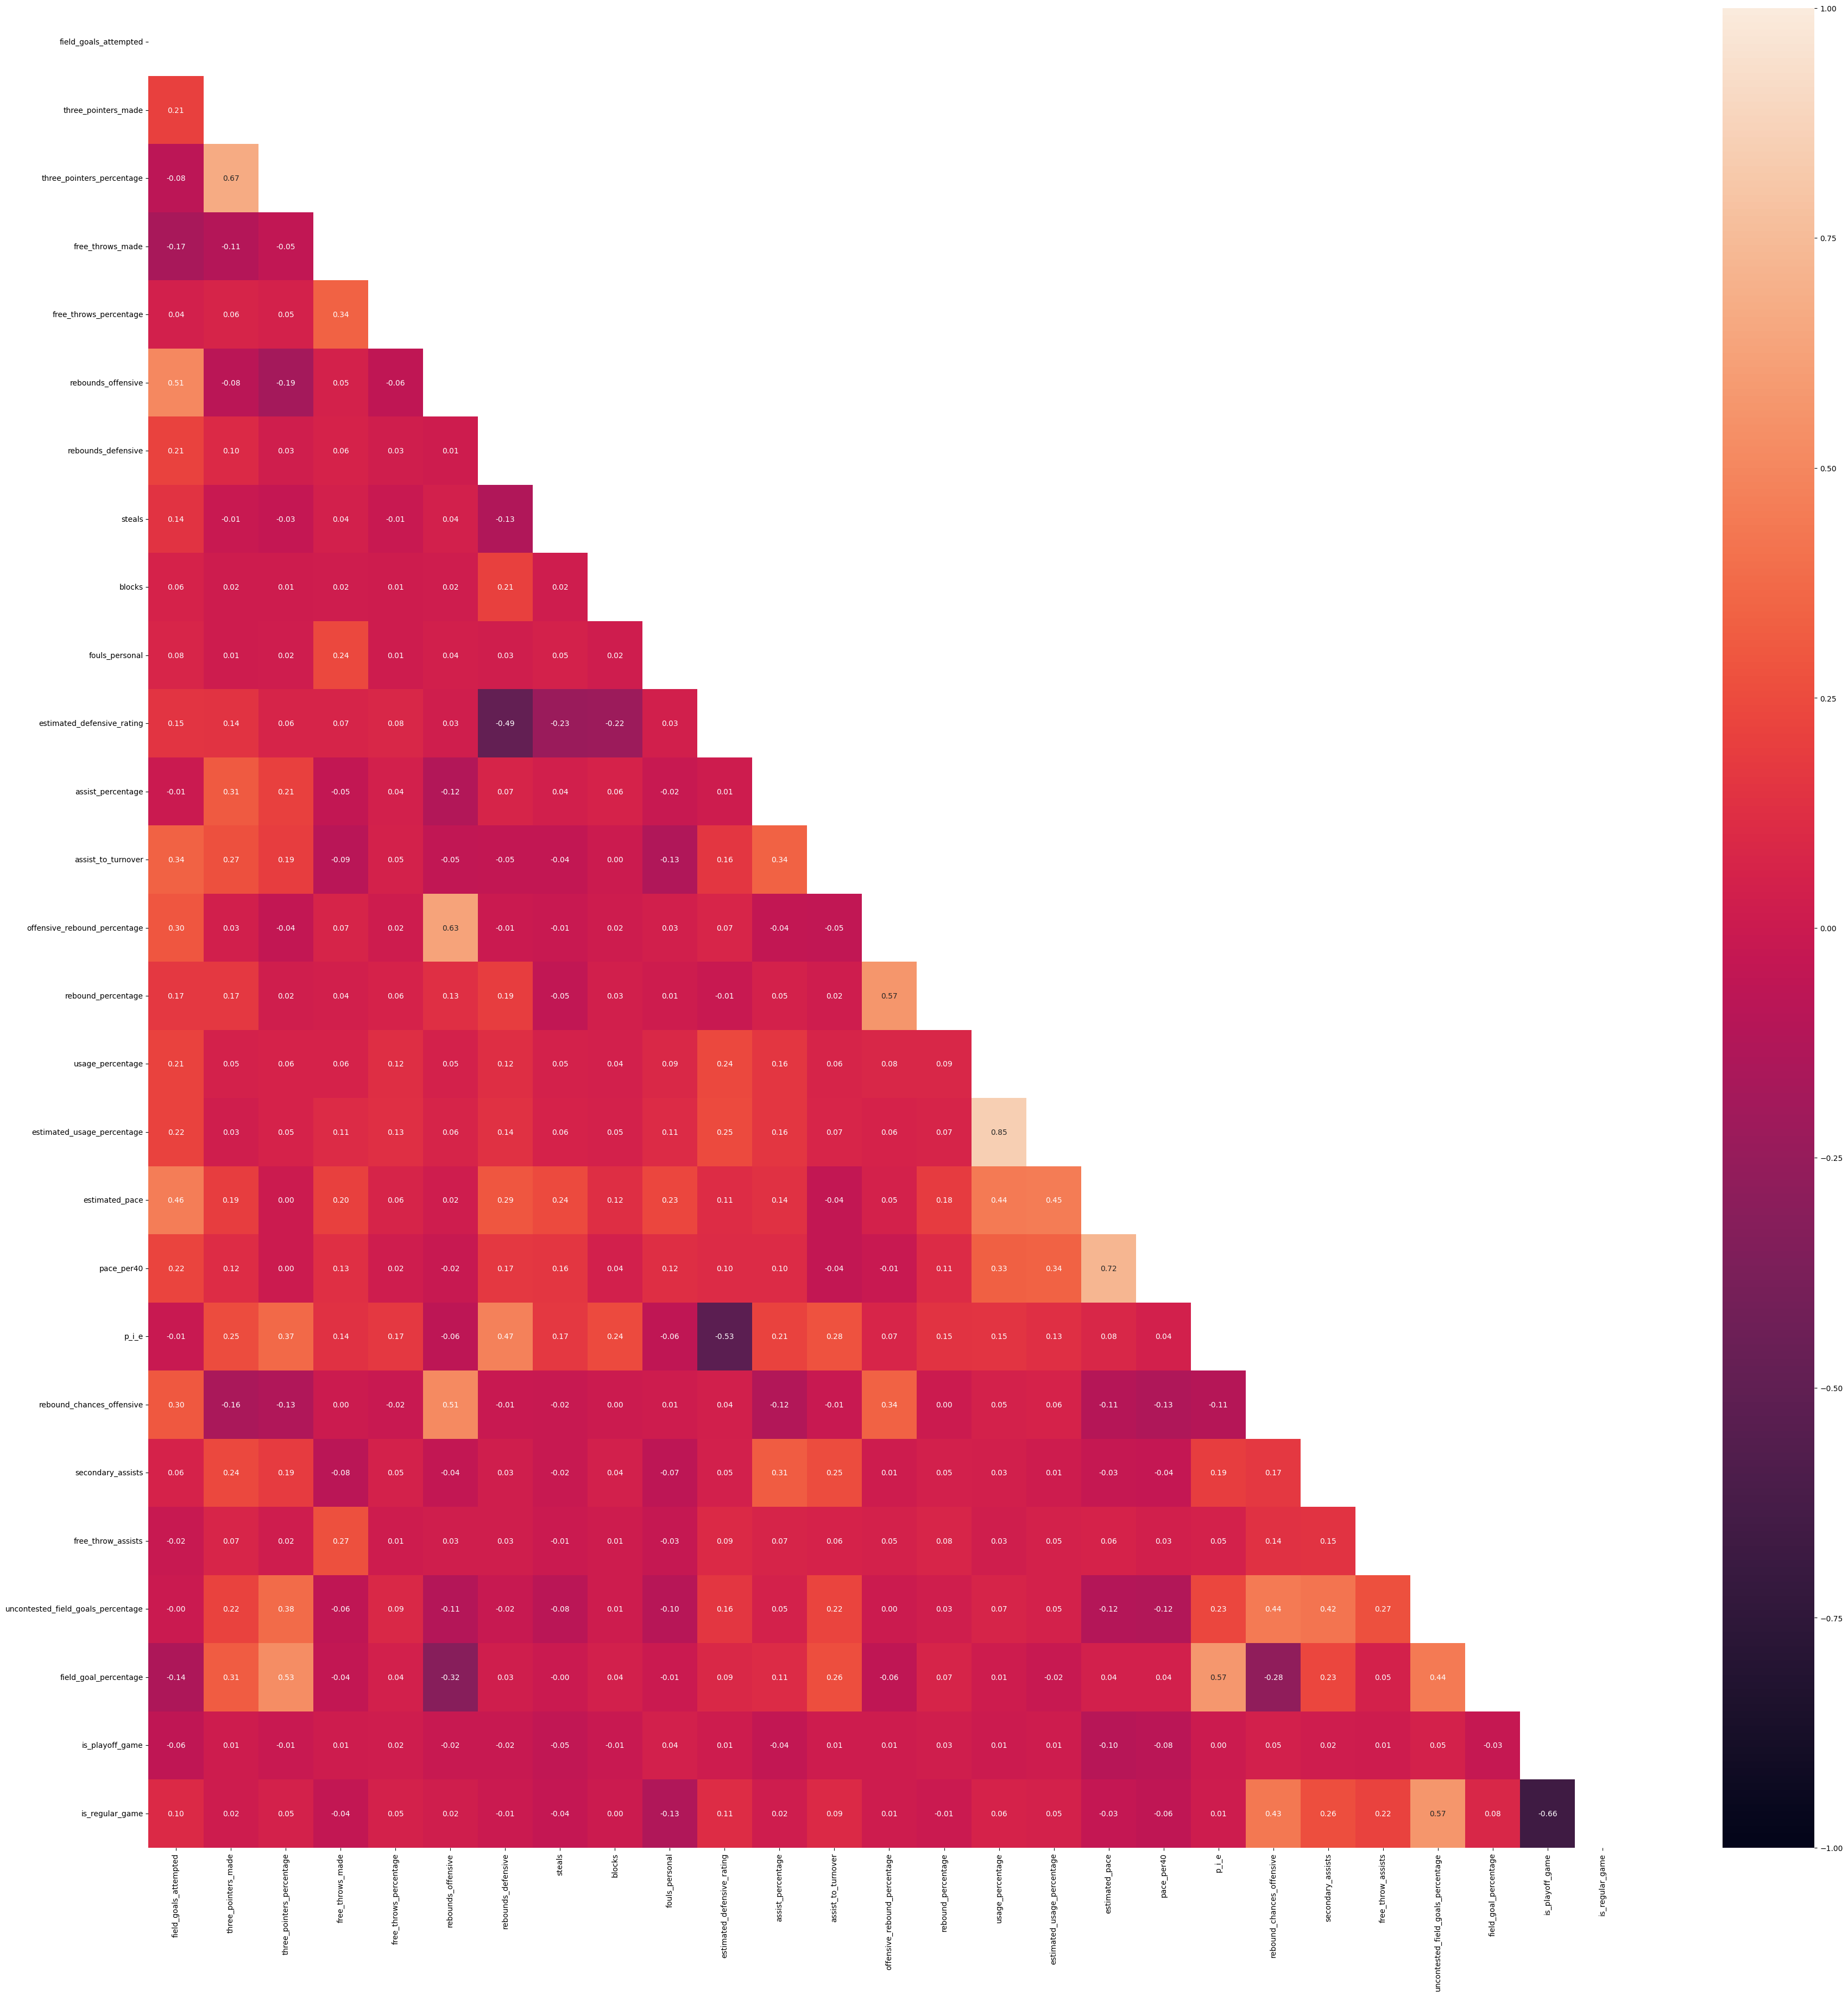

In [172]:
my_corrplot(df_combined, 'points')